# Rare Bottles: Finding Outliers in the Wine Dataset

## Introduction
In this analysis, we will look at the wine dataset.  The goal here is to find "special" or rare wines within the dataset.  To do this, we will employ outlier detection models.  Since the outliers models themselves can be opaque and difficult to interpret, we will use model-agnostic Shapley values to estimate the impact of each feature within the model.

In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/red-wine-quality-cortez-et-al-2009/winequality-red.csv


In [2]:
import lime
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

In [3]:
wine_data = pd.read_csv("/kaggle/input/red-wine-quality-cortez-et-al-2009/winequality-red.csv")

In [4]:
print("First few rows")
print(wine_data.head())

First few rows
   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        5  
1      9.8        5  
2    

In [5]:
print('Dataset data types')
print(wine_data.info())

Dataset data types
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB
None


In [6]:
print("Summary statistics")
print(wine_data.describe())

Summary statistics
       fixed acidity  volatile acidity  citric acid  residual sugar  \
count    1599.000000       1599.000000  1599.000000     1599.000000   
mean        8.319637          0.527821     0.270976        2.538806   
std         1.741096          0.179060     0.194801        1.409928   
min         4.600000          0.120000     0.000000        0.900000   
25%         7.100000          0.390000     0.090000        1.900000   
50%         7.900000          0.520000     0.260000        2.200000   
75%         9.200000          0.640000     0.420000        2.600000   
max        15.900000          1.580000     1.000000       15.500000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  1599.000000          1599.000000           1599.000000  1599.000000   
mean      0.087467            15.874922             46.467792     0.996747   
std       0.047065            10.460157             32.895324     0.001887   
min       0.012000           

In [7]:
print("Missing values")
print(wine_data.isnull().sum())

Missing values
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64


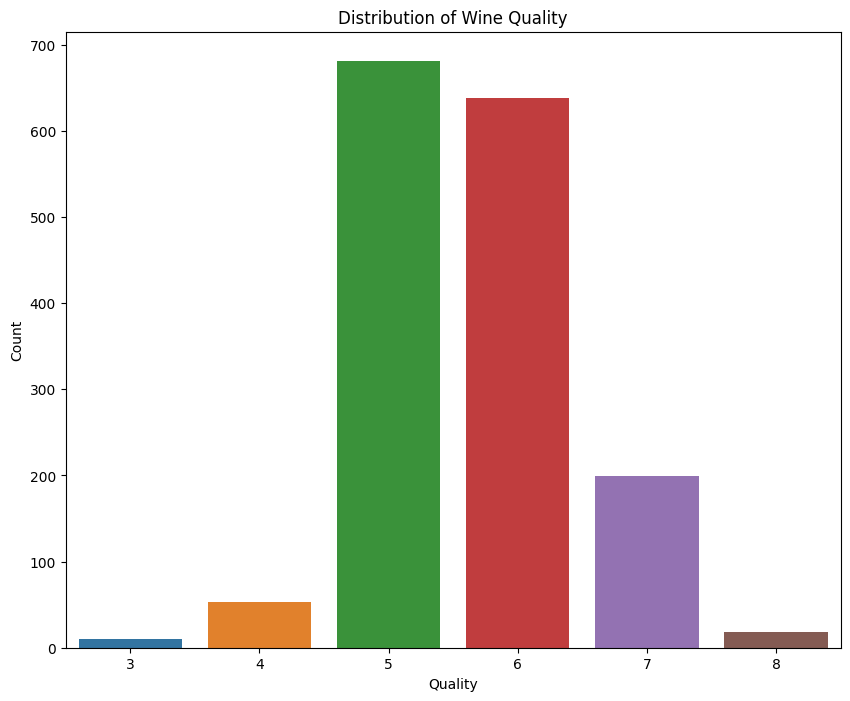

In [8]:
plt.figure(figsize=(10, 8))
sns.countplot(x='quality', data=wine_data)
plt.title("Distribution of Wine Quality")
plt.xlabel("Quality")
plt.ylabel("Count")
plt.show()

Quality is an integer between 3 and 8

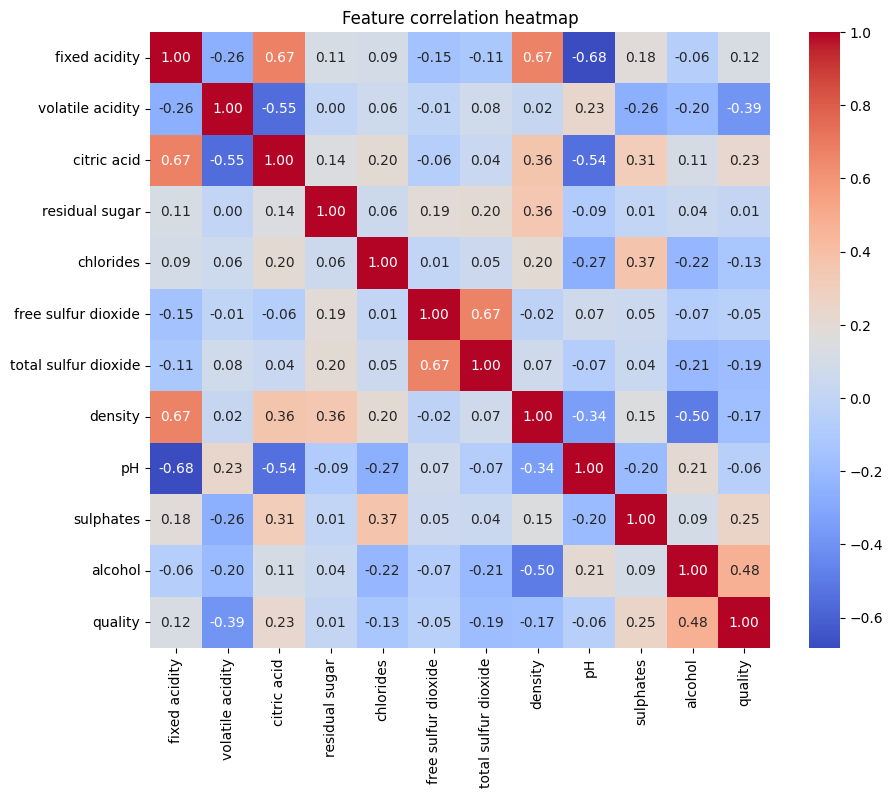

In [9]:
plt.figure(figsize=(10, 8))
correlation = wine_data.corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature correlation heatmap")
plt.show()

In [10]:
# Split X,y
y = wine_data.pop('quality')
X = wine_data.copy()

## Models

### Isolation Forest

In [11]:
# Build Isolation Forest model
isolation_forest = IsolationForest(contamination=0.05, random_state=42)
isolation_forest.fit(X)
outliers = isolation_forest.predict(X)
wine_data['Isolation Forest Outliers'] = outliers

X does not have valid feature names, but IsolationForest was fitted with feature names


Text(0.5, 1.0, 'SHAP value impact across entire dataset (Isolation Forest)')

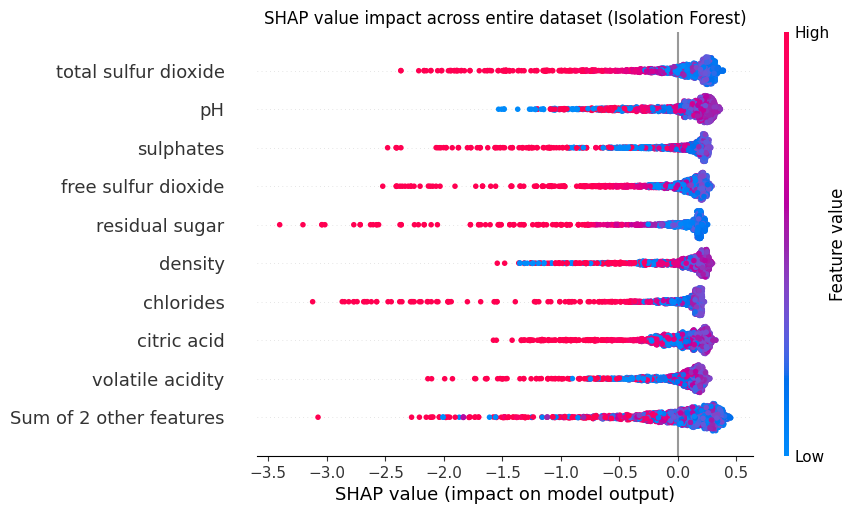

In [12]:
# SHAP explanations
explainer = shap.Explainer(isolation_forest)
shap_values = explainer(X)
shap.plots.beeswarm(shap_values, order=shap_values.abs.mean(0), show=False)
plt.title('SHAP value impact across entire dataset (Isolation Forest)')

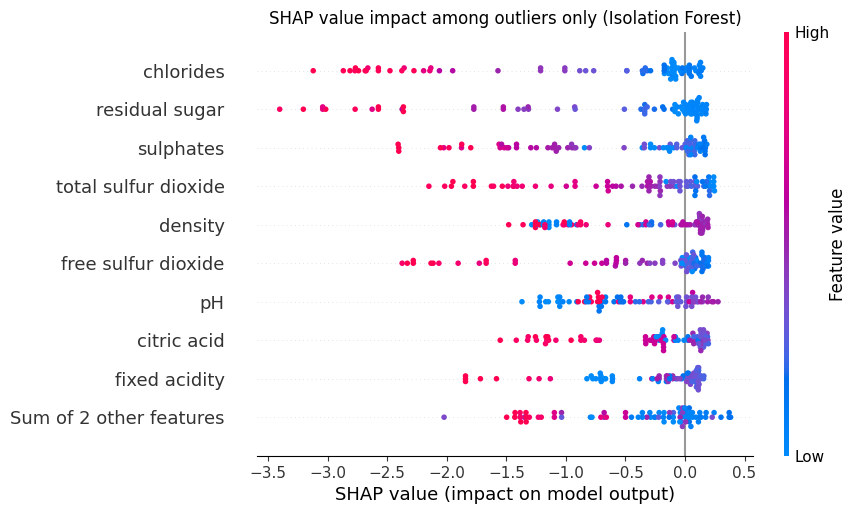

In [13]:
outlier_shap_values = shap_values[(wine_data['Isolation Forest Outliers'] == -1).values]
shap.plots.beeswarm(outlier_shap_values, order=outlier_shap_values.abs.mean(0), show=False)
plt.title('SHAP value impact among outliers only (Isolation Forest)')
plt.show()

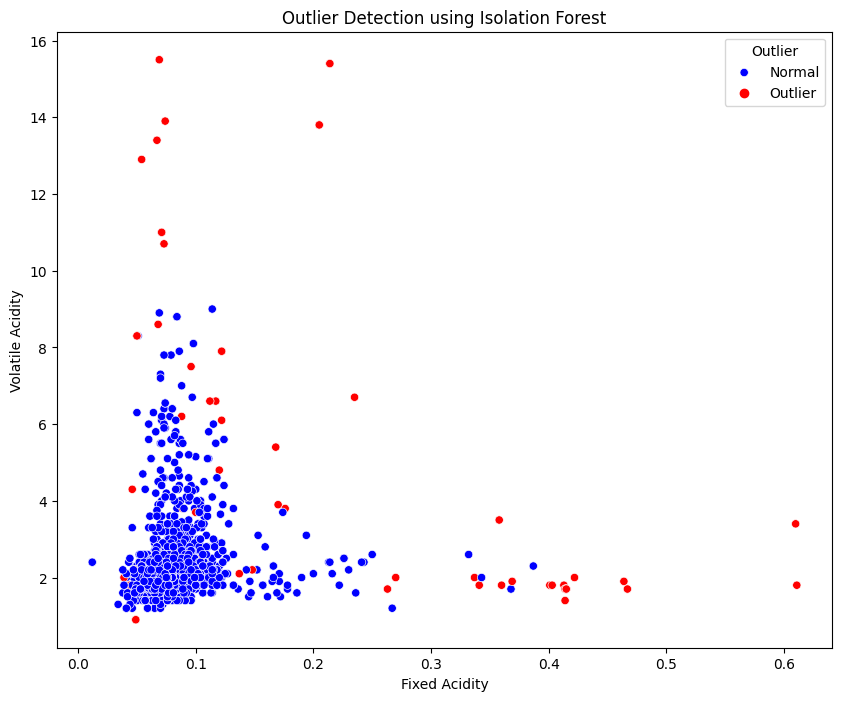

In [14]:
# Visualization of outlier locations in top 2 features
plt.figure(figsize=(10, 8))
sns.scatterplot(x='chlorides', y='residual sugar', hue='Isolation Forest Outliers', palette={1: 'blue', -1: 'red'}, data=wine_data)
plt.title("Outlier Detection using Isolation Forest")
plt.xlabel("Fixed Acidity")
plt.ylabel("Volatile Acidity")
plt.legend(['Normal', 'Outlier'], title="Outlier")
plt.show()

In [15]:
print('Quality from Isolation Forest groups')
normal_qmean = y[wine_data['Isolation Forest Outliers'] == -1].mean()
print(f'Mean quality of normal wines: {normal_qmean:.2f}')
outlier_qmean = y[wine_data['Isolation Forest Outliers'] == 1].mean()
print(f'Mean quality of outlier wines: {outlier_qmean:.2f}')

Quality from Isolation Forest groups
Mean quality of normal wines: 5.59
Mean quality of outlier wines: 5.64


### One Class SVM

In [16]:
# Build One Class SVM
ocsvm = OneClassSVM(nu=0.05)
ocsvm.fit(X)
outliers = ocsvm.predict(X)
wine_data['One Class SVM Outliers'] = outliers

PermutationExplainer explainer: 1600it [08:03,  3.27it/s]


Text(0.5, 1.0, 'SHAP value impact across entire dataset (OneClassSVM)')

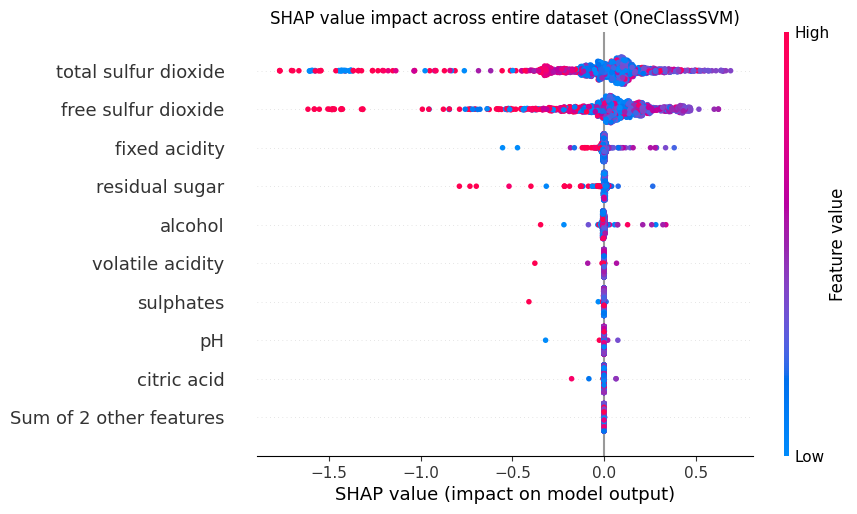

In [17]:
# SHAP explanations
explainer = shap.Explainer(ocsvm.predict, X)
shap_values = explainer(X)
shap.plots.beeswarm(shap_values, order=shap_values.abs.mean(0), show=False)
plt.title('SHAP value impact across entire dataset (OneClassSVM)')

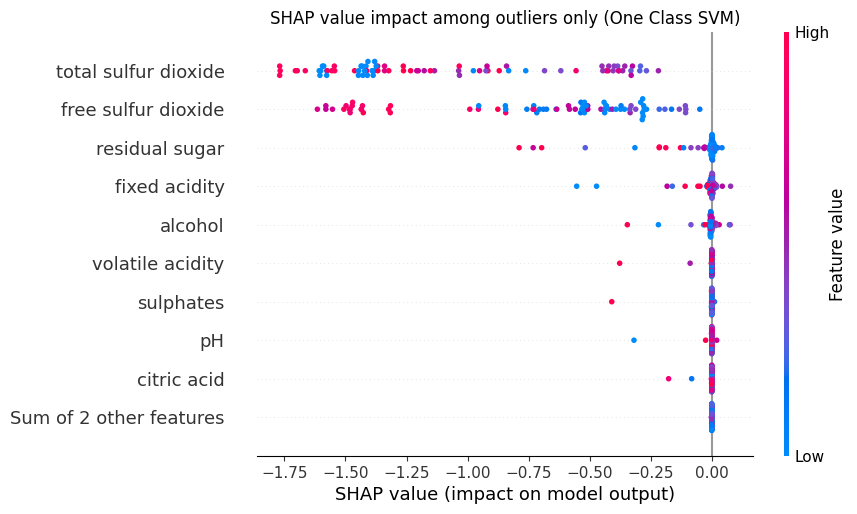

In [18]:
outlier_shap_values = shap_values[(wine_data['One Class SVM Outliers'] == -1).values]
shap.plots.beeswarm(outlier_shap_values, order=outlier_shap_values.abs.mean(0), show=False)
plt.title('SHAP value impact among outliers only (One Class SVM)')
plt.show()

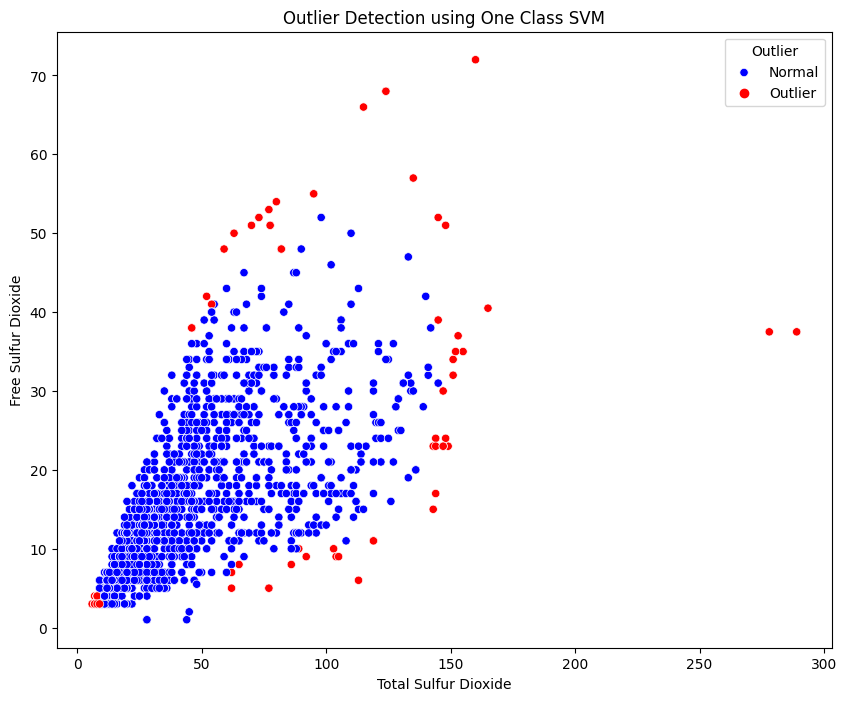

In [19]:
# Visualization of outlier locations in top 2 features
plt.figure(figsize=(10, 8))
sns.scatterplot(x='total sulfur dioxide', y='free sulfur dioxide', hue='One Class SVM Outliers', palette={1: 'blue', -1: 'red'}, data=wine_data)
plt.title("Outlier Detection using One Class SVM")
plt.xlabel("Total Sulfur Dioxide")
plt.ylabel("Free Sulfur Dioxide")
plt.legend(['Normal', 'Outlier'], title="Outlier")
plt.show()

In [20]:
print('Quality from One Class SVC groups')
normal_qmean = y[wine_data['One Class SVM Outliers'] == -1].mean()
print(f'Mean quality of normal wines: {normal_qmean:.2f}')
outlier_qmean = y[wine_data['One Class SVM Outliers'] == 1].mean()
print(f'Mean quality of outlier wines: {outlier_qmean:.2f}')

Quality from One Class SVC groups
Mean quality of normal wines: 5.49
Mean quality of outlier wines: 5.64


# Discussion
In this analysis, we compare two different methods for detecting outliers: Isolation Forest and One Class SVM.  The results show very different but interesting results.  Using Shapley values to interpret the feature importance, we can see that for both models, total sulfur dioxide was the most important feature in determining whether an instance was an outlier or not.  However, when interpreting the shapley values of just the outliers themselves, we see that different features had different impacts on the model outputs.  For Isolation Forest outliers, high chlorides, residual sugar, and sulphates had high impact on judging the instance to be an outlier.   For One Class SVC, high total sulfur dioxide and free sulfur dioxide contributed to determining outliers, but the results are a bit mixed.  Some instances with low levels of total sulfur dioxide also were classified as outliers.

Using scatterplots of the top features with highest impact to Shapley values, we can see that the outliers of the Isolation Forest model clearly had extreme values in at least one dimension.  For One Class SVC, it was very interesting to see that outliers formed a sort of ring on the outside of the distribution.  There is clearly a pattern there.  However, this pattern is harder to interpret, despite using Shapely values to help us interpret the results.

For this case, it seemed that Isolation Forest is a useful model to select outliers in the wine dataset.

For both models, mean quality of the wine was higher in the outlier group rather than the normal group, which is an interesting finding.